In [2]:
!pip -q install -U ultralytics pillow requests  # run once if needed

from ultralytics import YOLO
from PIL import Image, ImageOps
import requests, io, os, json

Saved annotated image to: None


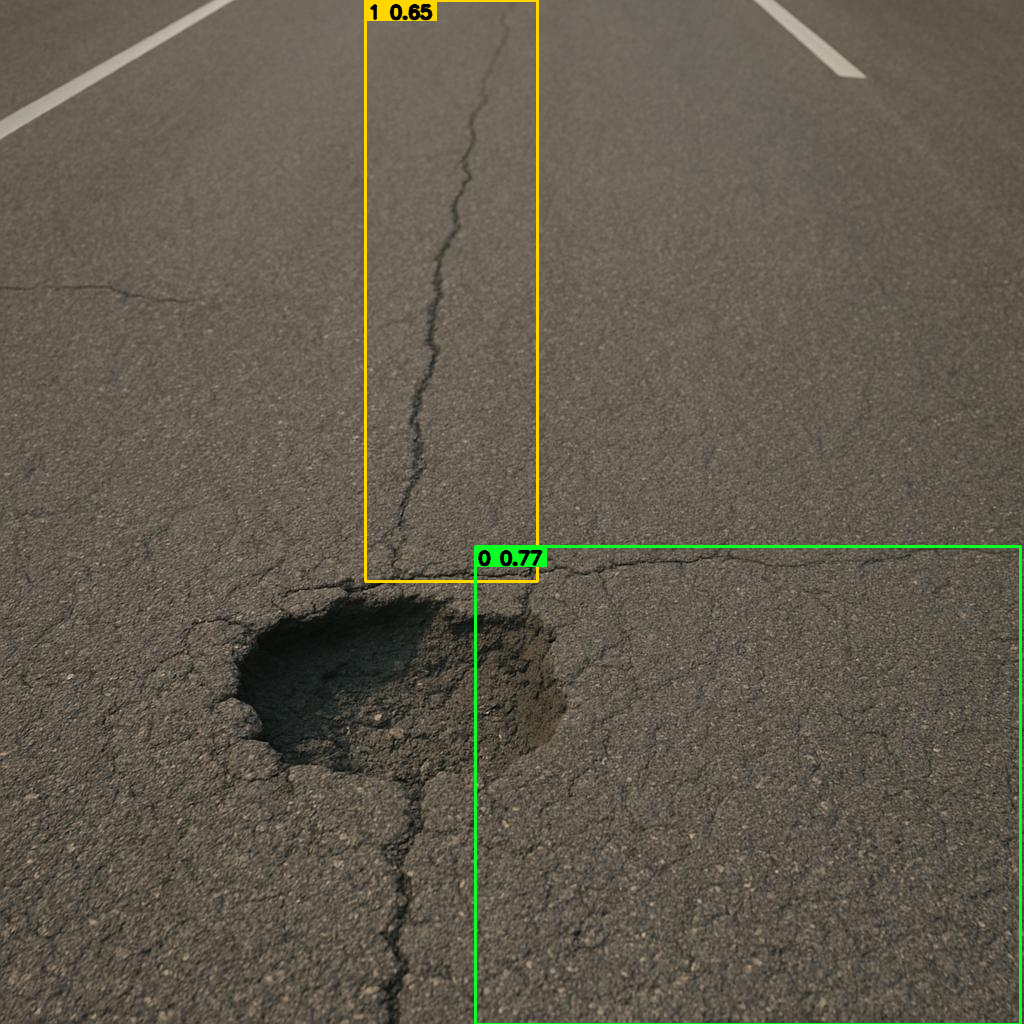

Kept 2 boxes → demo_road_clean.png

Detections (filtered):
- 1 | conf=0.65 | xyxy=[365.1, 0.0, 538.0, 581.9]
- 0 | conf=0.77 | xyxy=[475.8, 546.3, 1021.0, 1024.0]

Dropped (with reason):
- 0 | 0.77 | reason=too_big(0.248) | xyxy=[475.8, 546.3, 1021.0, 1024.0]
- 4 | 0.64 | reason=conf | xyxy=[0.3, 258.9, 212.8, 317.9]
- 0 | 0.41 | reason=conf | xyxy=[0.2, 272.4, 223.9, 1024.0]


In [16]:
import cv2, numpy as np, os

# model.names must match training order
CLASS_NAMES = dict(enumerate(model.names)) if isinstance(model.names, (list, tuple)) else model.names

# ---- Per-class thresholds (more permissive for potholes) ----
CONF_BY_CLASS = {
    0: 0.45,  # pothole (lowered)
    1: 0.60,
    2: 0.60,
    3: 0.60,
    4: 0.65,
}
MIN_AREA_FRAC = {             # too small -> reject
    0: 0.0006,  # pothole (lowered)
    1: 0.0007,
    2: 0.0007,
    3: 0.0012,
    4: 0.0007,
}
MAX_AREA_FRAC = {             # too big -> reject
    0: 0.20,   # pothole (raised a bit)
    1: 0.12,
    2: 0.12,
    3: 0.20,
    4: 0.12,
}
# Roundness (short/long). Lower means we tolerate thinner shapes.
MIN_AR_THIN = {
    0: 0.18,  # pothole (relaxed from 0.25)
    1: 0.10,
    2: 0.10,
    3: 0.20,
    4: 0.10,
}

def clamp(v, lo, hi): return max(lo, min(hi, v))

def draw_label_inside(img, x1, y1, x2, y2, text, color):
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    px = int(clamp(x1 + 3, 0, img.shape[1] - tw - 4))
    py = int(clamp(y1 + th + 4, th + 4, img.shape[0] - 4))
    cv2.rectangle(img, (px-2, py-th-4), (px+tw+2, py+2), color, -1)
    cv2.putText(img, text, (px, py), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)

def keep_box(cls_id, conf, xyxy, W, H, dbg):
    if conf < CONF_BY_CLASS.get(cls_id, 0.6):
        dbg.append("conf"); return False
    x1, y1, x2, y2 = map(float, xyxy)
    w, h = max(1, x2 - x1), max(1, y2 - y1)
    area_frac = (w * h) / (W * H)
    if area_frac < MIN_AREA_FRAC.get(cls_id, 0.001):
        dbg.append(f"too_small({area_frac:.5f})"); return False
    if area_frac > MAX_AREA_FRAC.get(cls_id, 0.2):
        dbg.append(f"too_big({area_frac:.3f})"); return False
    short_over_long = min(w, h) / max(w, h)
    if short_over_long < MIN_AR_THIN.get(cls_id, 0.1):
        if cls_id == 0:
            dbg.append(f"thin_pothole({short_over_long:.2f})"); return False
    elif cls_id in (1, 2, 4) and short_over_long > 0.6:
        dbg.append(f"round_crack({short_over_long:.2f})"); return False
    return True

# --- Predict (we still use generous pre-NMS, then filter ourselves)
res = model.predict(
    source=IMG_PATH,
    conf=0.25,
    iou=0.45,
    imgsz=960,
    max_det=100,
    agnostic_nms=False,
    verbose=False
)
r = res[0]
print("Saved annotated image to:", r.save_dir)

img_bgr = cv2.imread(IMG_PATH)
H, W = img_bgr.shape[:2]
colors = [(36,255,12), (0,215,255), (255,191,0), (255,0,127), (180,105,255)]

kept, dropped = [], []
if r.boxes is not None and len(r.boxes) > 0:
    for b in r.boxes:
        cls_id = int(b.cls.item())
        conf   = float(b.conf.item())
        xyxy   = b.xyxy[0].tolist()
        reasons = []
        if keep_box(cls_id, conf, xyxy, W, H, reasons):
            kept.append((cls_id, conf, xyxy))
        else:
            dropped.append((cls_id, conf, xyxy, reasons))

# ---- RESCUE: if no pothole kept, try to add the best dropped pothole under looser gates
if not any(k[0] == 0 for k in kept):
    pothole_candidates = [(cls, conf, xyxy, rsn) for (cls, conf, xyxy, rsn) in dropped if cls == 0 and conf >= 0.40]
    if pothole_candidates:
        # rank by confidence
        pothole_candidates.sort(key=lambda t: t[1], reverse=True)
        cls_id, conf, xyxy, _ = pothole_candidates[0]
        # loose sanity check (just area bounds)
        x1, y1, x2, y2 = map(float, xyxy)
        area_frac = ((x2-x1)*(y2-y1))/(W*H)
        if 0.0004 <= area_frac <= 0.25:
            kept.append((cls_id, conf, xyxy))

# draw kept
for cls_id, conf, (x1, y1, x2, y2) in kept:
    c = colors[cls_id % len(colors)]
    cv2.rectangle(img_bgr, (int(x1), int(y1)), (int(x2), int(y2)), c, 2)
    label = f"{CLASS_NAMES.get(cls_id, cls_id)} {conf:.2f}"
    draw_label_inside(img_bgr, x1, y1, x2, y2, label, c)

out_path = "demo_road_clean.png"
cv2.imwrite(out_path, img_bgr)
display(Image.open(out_path))

print(f"Kept {len(kept)} boxes → {out_path}")
if kept:
    print("\nDetections (filtered):")
    for cls_id, conf, xyxy in kept:
        name = CLASS_NAMES.get(cls_id, str(cls_id))
        print(f"- {name} | conf={conf:.2f} | xyxy={[round(v,1) for v in xyxy]}")
if dropped:
    print("\nDropped (with reason):")
    for cls_id, conf, xyxy, reasons in dropped[:10]:
        name = CLASS_NAMES.get(cls_id, str(cls_id))
        print(f"- {name} | {conf:.2f} | reason={'+'.join(reasons)} | xyxy={[round(v,1) for v in xyxy]}")
